# Solving The Advection Equation

### Sometimes before you can make a hard thing easy you have to make an easy thing hard.

We're going to solve the Advection Equation here. 

$$
\partial_t u(t, x) + a \partial_x u(t, x) = 0
$$

Here $a$ is the advection velocity (dimensions Length / Time) and $u$ is the quantity being advected.  The exact solution is trivial to write down: $u(t, x) = u(x - at, 0)$, but that is not the point.  The advection equation is the simplest example of a _conservation law_ partial differential equation, and is used a great deal to test numerical algorithms.  Before you can use your algorithm for hydrodynamics, you have to show it can deal with advection.

Here we build a simple method to solve this equation to 1st order in space and time.  More sophisticated methods can go to substantially higher order.

### Spatial Grid

First we need to define our discretization of space.

This is a "cell-centered" grid that breaks up the interval $[a, b]$ into $N_x$ cells of width $\Delta x = (b-a)/N_x$.  There are $N_x+1$ _faces_ in between the cells: $x_{e,i} = a + i \Delta x$ and $N_x$ cell centers at $x_i = a + (i+1/2)\Delta x$.  The `make_grid` function also allows for $N_g$ _ghost zones_ on each side of the boundary, which are useful for applying boundary conditions.

In [1]:
function make_grid(a, b, Nx, Ng)
    
    # The desired cell-width
    dx = (b - a) / Nx
    
    # First get the edges of all the cells, adding ghost zones to the left and right
    xe = LinRange(a - Ng*dx, b + Ng*dx, Nx + 2*Ng + 1)
    
    # Now the cell centers are just the average of the left & right cell faces
    xL = xe[begin:end-1]
    xR = xe[begin+1:end]
    x = 0.5*(xL + xR)
    
    return dx, x, xe
end

make_grid (generic function with 1 method)

### Plotting Utilities

Just a couple useful functions for plotting our data.

## You may have to change GLMakie to WGLMakie 

In [2]:
using GLMakie
GLMakie.activate!()

function make_figure()
    fig = Figure()
    ax = Axis(fig[1,1])
    return fig, ax
end

function add_to_plot(ax, x, f)
    lines!(ax, x, f)
    # plot!(ax, x, f)
end

add_to_plot (generic function with 1 method)

### Initial Conditions

These functions will return an array that can be used as an initial state for our solve.

In [3]:
function init_bump(x, x0, width, amp)
    # A smooth bump of amplitude `amp` and width `w` at position `x0`.
    f = similar(x)
    for i in 1:length(x)
        if ((x[i]-x0)/width)^2 >= 1.0
            f[i] = 0.0
        else
            f[i] = amp*cos(0.5*pi*(x[i]-x0)/width)^2
        end
    end
    return f
end

function init_square(x, x0, width, amp)
    # A square wave of amplitude `amp` and width `w` at position `x0`.
    f = similar(x)
    for i in 1:length(x)
        if ((x[i]-x0)/width)^2 >= 1.0
            f[i] = 0.0
        else
            f[i] = amp
        end
    end
    return f
end

init_square (generic function with 1 method)

### Boundary Conditions

Every time step, we need to set the ghost zones to have appropriate values.  We will do this in two ways: a _periodic_ boundary condition that wraps the domain around on itself, and a _copy_ or _outflow_ boundary condition that copies the nearest real zone into the ghost zone (setting the gradient at the boundary to 0)

In [4]:
function no_BC(u)
    # do nothing
end

function periodic_L(u)
    # Periodic BC on the left edge.
    u[begin] = u[end-1]
end

function periodic_R(u)
    # Periodic BC on the right edge.
    u[end] = u[begin+1]
end

function copy_L(u)
    # Copy BC on the left edge.
    u[begin] = u[begin+1]
end

function copy_R(u)
    # Copy BC on the right edge.
    u[end] = u[end-1]
end

copy_R (generic function with 1 method)

## Grid Timestep Function

These functions update our grid using Forward-Euler.  The first performs a single step.  The second computes many steps until a desired time $t_final$.

In [5]:
function timestep(u, dx, dt, a, udot_f, bc_L_f, bc_R_f)
    N = length(u)
    
    udot = similar(u)
    
    # First compute the time derivative of u on for each (real) zone
    for i in 2:N-1 
        udot[i] = udot_f(u[i-1], u[i], u[i+1], a, dx)
    end

    # Now update each real zone in-place
    for i in 2:N-1 
        u[i] += dt * udot[i]
    end
    
    # Now apply the boundary condition functions to set the ghost zones.
    bc_L_f(u)
    bc_R_f(u)
end

function evolve(u, t_final, dx, dt, a, udot_f, bc_L_f, bc_R_f)
    t = 0
    
    while t < t_final

        if t + dt > t_final
            dt = t_final - t
        end
            
        timestep(u, dx, dt, a, udot_f, bc_L_f, bc_R_f)
        t += dt
    end
end

evolve (generic function with 1 method)

# Per-Cell update function -- where the magic happens!

This function gets called on each cell to compute the time-derivative: $\partial_t u = -a\partial_x u$

In [22]:
function udot_ftcs(uL, uC, uR, a, dx)
    # Write a function that computes du/dt for the advection equation.
    return -a * (uR - uL) / (2*dx)
end

function udot_ftls(uL, uC, uR, a, dx)
    # Write a function that computes du/dt for the advection equation.
    # C = u_j
    # L = u_{j-1}
    return -a * (uC - uL) / (dx)
end

udot_ftls (generic function with 1 method)

# Test it out down here!

Let's start with the FTCS method.  Evolving with $N_x = 100$ and $\Delta t = 0.005$ to a final time of $T = 0.1$

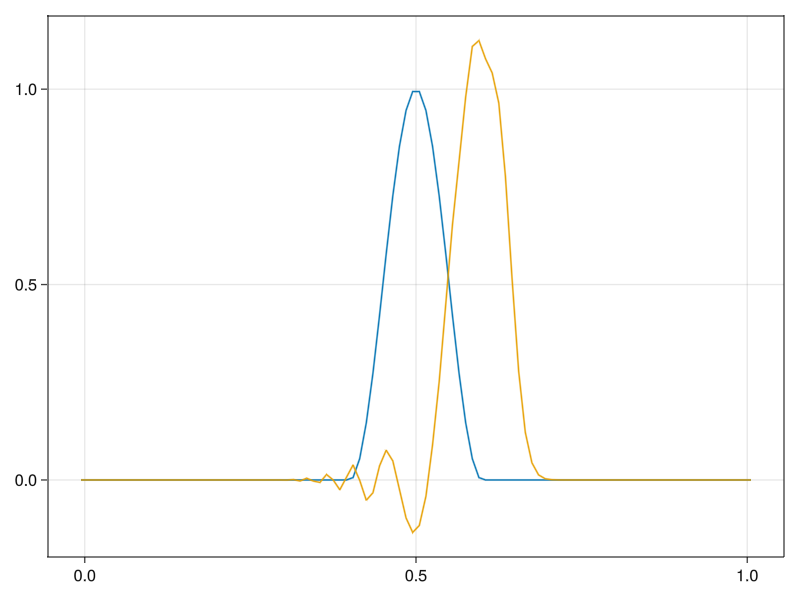

In [41]:
dx, x, xe = make_grid(0, 1, 100, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

a = 1.0
dt = 0.005

t_total = 0.1

evolve(u, t_total, dx, dt, a, udot_ftcs, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig

That looks ok, but those extra waves (wiggles) are suspicious.  What if we evolve for twice as long?

Evolving with $N_x = 100$ and $\Delta t = 0.005$ to a final time of $T = 0.3$

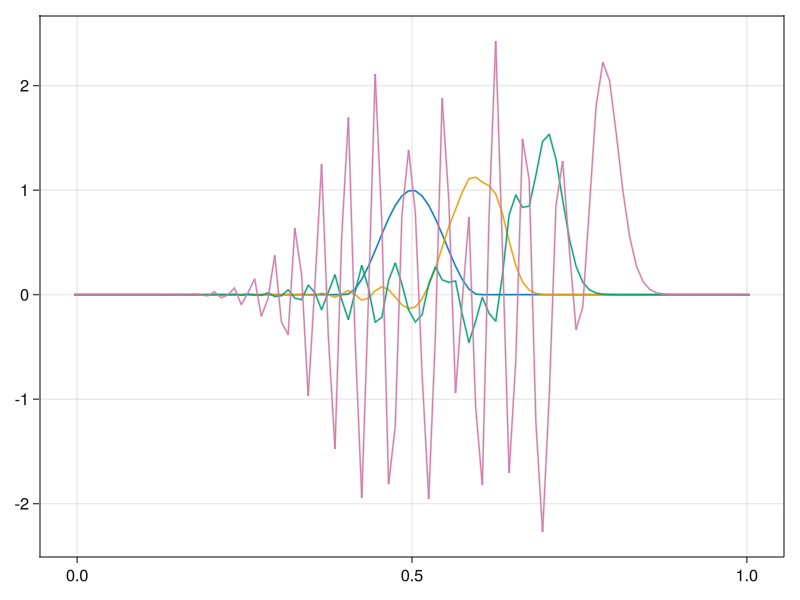

In [49]:
dx, x, xe = make_grid(0, 1, 100, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

dt = 0.005
a = 1.0
t_run = 0.1

#  run for t_run time.
evolve(u, t_total, dx, dt, a, udot_ftcs, periodic_L, periodic_R)
add_to_plot(ax, x, u)

#  run for t_run time again.
evolve(u, t_total, dx, dt, a, udot_ftcs, periodic_L, periodic_R)
add_to_plot(ax, x, u)


#  run for t_run time again.
evolve(u, t_total, dx, dt, a, udot_ftcs, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig

Oh NO.  The oscillations have completely destroyed the solution.  Maybe if we increase the resolution?

Evolving with $N_x = 400$ and $\Delta t = 0.005$ to a final time of $T = 0.2$

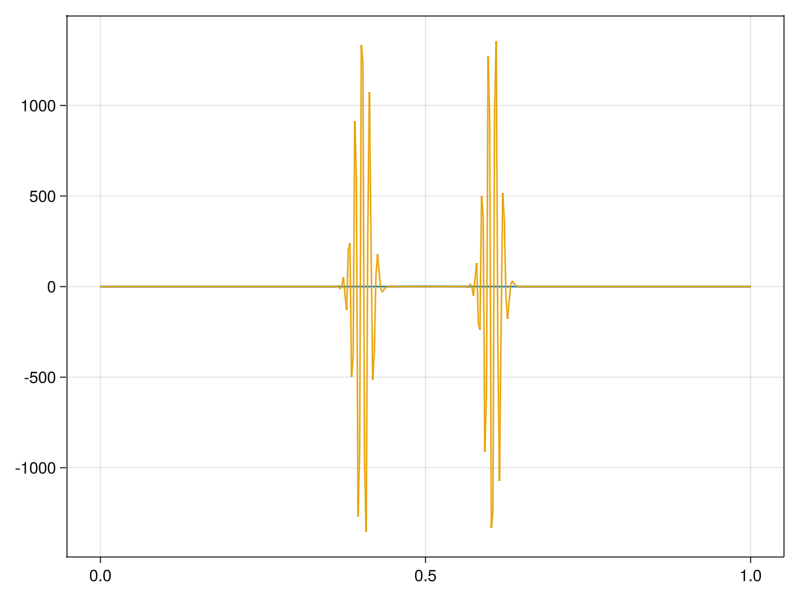

In [46]:
dx, x, xe = make_grid(0, 1, 400, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

dt = 0.005
a = 1.0
t_total = 0.1

evolve(u, t_total, dx, dt, a, udot_ftcs, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig

That is even worse.  This algorithm seems pathological: increasing our resolution makes the error worse.

Indeed, von Neumann error analysis shows the FTCS scheme for the advection equation is _unconditionally unstable_.

A better algorithm takes into account that information in hyperbolic PDEs moves along _characteristics_, and in the advection equation the characteristics move uniformly _to the right_. 

We can *upwind* our solution by using a biased estimate for $\partial_x u$, only using $u^n_{j-1}$ and $u^n_j$.  This gives us the Forward-Time-Left-Space algorithm or FTLS.

FTLS is stable if $\Delta t < \Delta x / a$, the Courant-Freidrichs-Lewy (CFL) condition. We can enforce this by setting $\Delta t$ with the equation:

$$
\Delta t = \mathtt{CFL}\times \Delta x / a
$$

Where $\mathtt{CFL} < 1.0$ is a constant.

Let's try FTLS with $CFL = 0.9$, $N_x = 100$, and $T = 0.3$

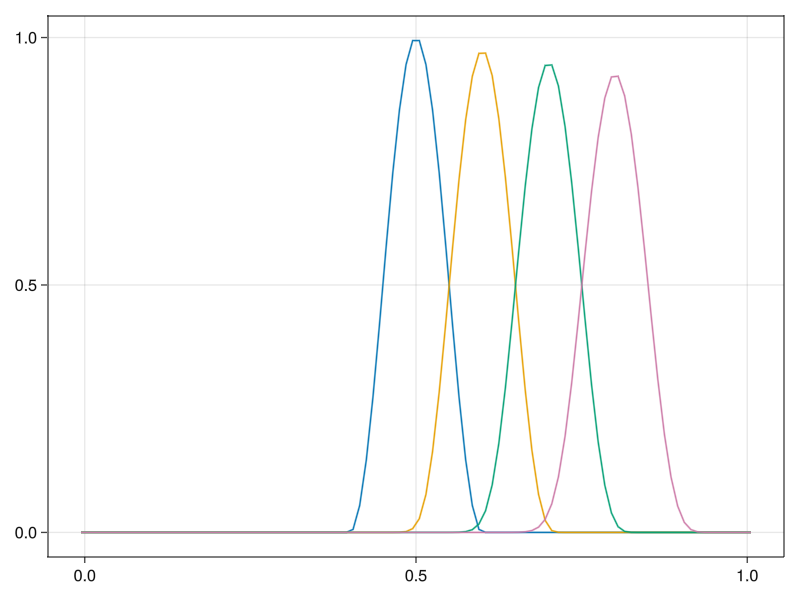

In [51]:
dx, x, xe = make_grid(0, 1, 100, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

a = 1.0

CFL = 0.9
dt = CFL * dx / a

t_run = 0.1

# run to 0.1 & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.1 more (0.2 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.1 more (0.3 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig

Oh that looks MUCH better!  What about higher resolution and CFL?

$CFL = 0.99$, $N_x = 400$, and $T = 1.0$

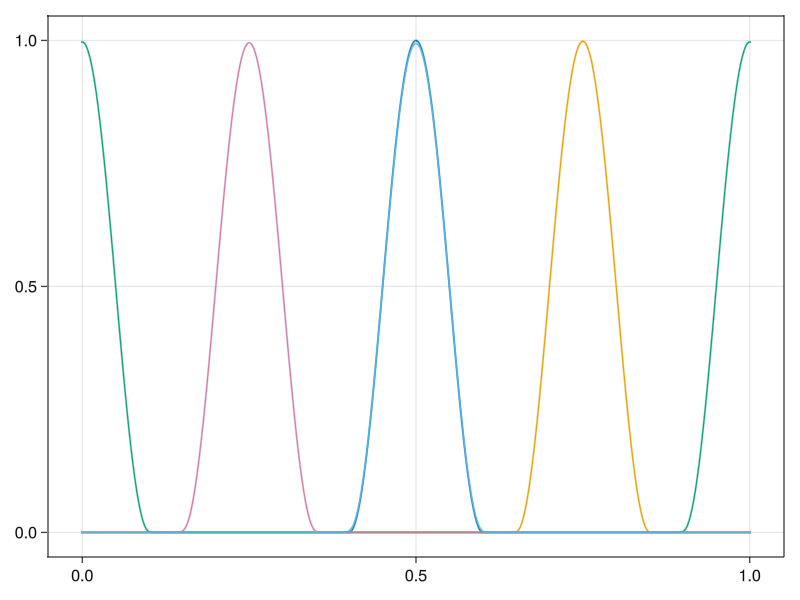

In [59]:
dx, x, xe = make_grid(0, 1, 400, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

a = 1.0

CFL = 0.99
dt = CFL * dx / a

t_run = 0.25

# run to 0.25 & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (0.5 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (0.75 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (1.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig

Beautiful! The solution runs through the whole domain and comes back nearly to itself. What if we changed the CFL to 1.01, just to see?

$CFL = 1.01$, $N_x = 400$, and $T = 1.0$

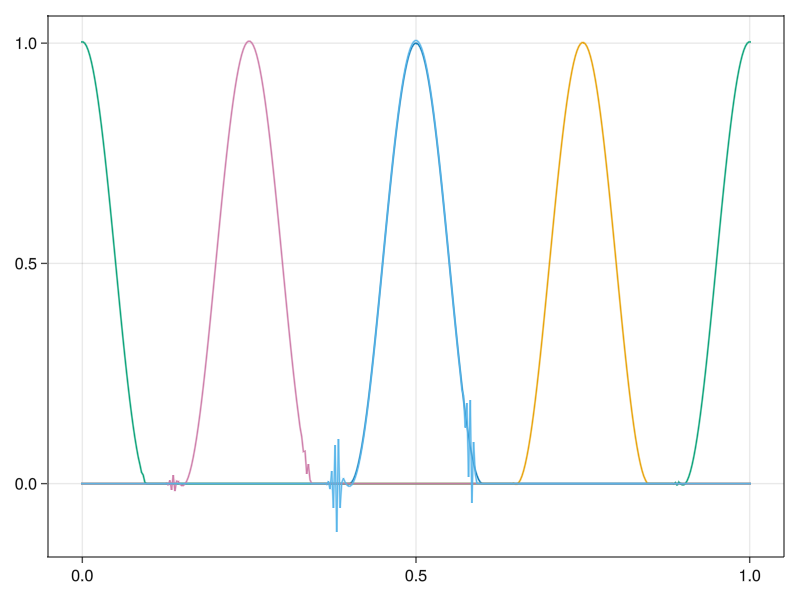

In [62]:
dx, x, xe = make_grid(0, 1, 400, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

a = 1.0

CFL = 1.01
dt = CFL * dx / a

t_run = 0.25

# run to 0.25 & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (0.5 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (0.75 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (1.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig

Oh, that looks dangerous.  If the resolution is increased?

$CFL = 1.01$, $N_x = 800$, and $T = 1.0$

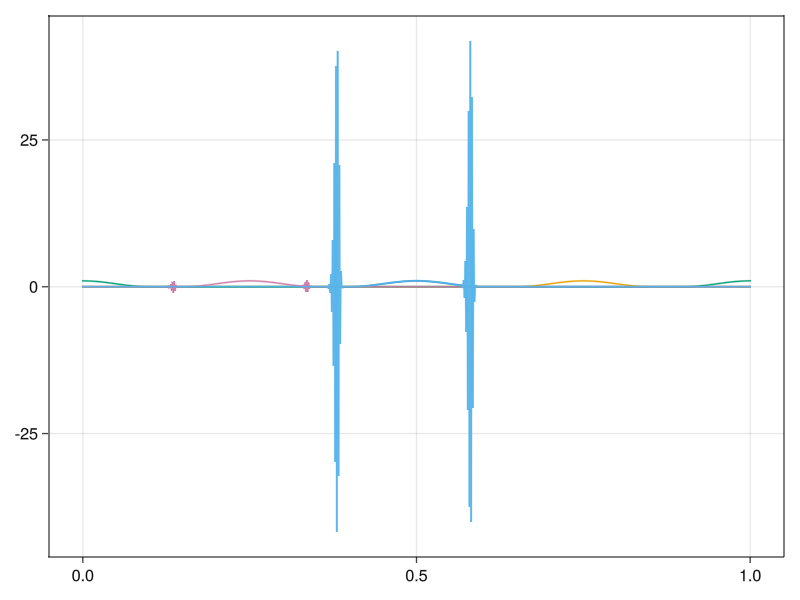

In [70]:
dx, x, xe = make_grid(0, 1, 800, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

a = 1.0

CFL = 1.01
dt = CFL * dx / a

t_run = 0.25

# run to 0.25 & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (0.5 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (0.75 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 0.25 more (1.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig

Again, catastrophe.   Ignore the CFL condition at your peril!

Here's a longer one, back to an appropriate CFL.  Plotted every period around the domain.

$CFL = 0.9$, $N_x = 800$, and $T = 8.0$

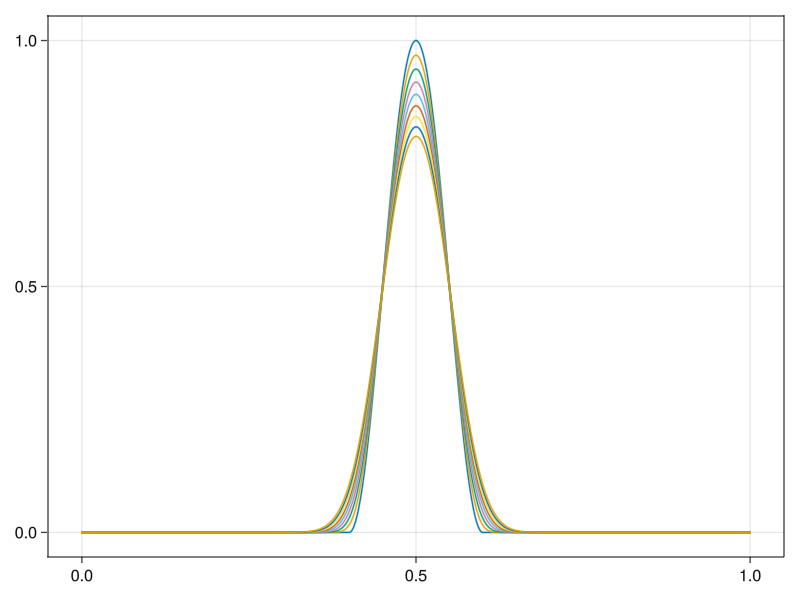

In [71]:
dx, x, xe = make_grid(0, 1, 800, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

a = 1.0

CFL = 0.9
dt = CFL * dx / a

t_run = 1.0

# run to 1.0 & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (2.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (3.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (4.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (5.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (6.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (7.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (8.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig

And again, with increased CFL.  The profile is preserved well for many orbits of the domain!

$CFL = 0.99$, $N_x = 800$, and $T = 8.0$

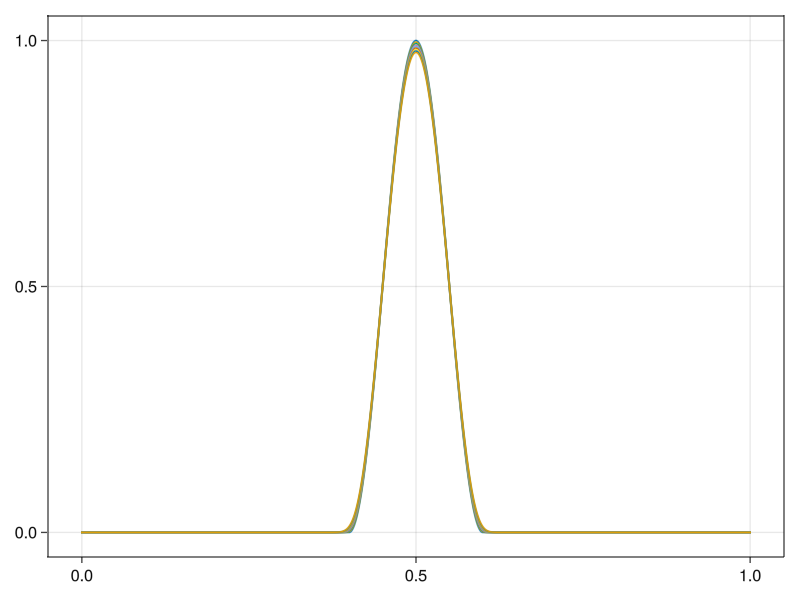

In [72]:
dx, x, xe = make_grid(0, 1, 800, 1)

u = init_bump(x, 0.5, 0.1, 1)

fig, ax = make_figure()
add_to_plot(ax, x, u)

a = 1.0

CFL = 0.99
dt = CFL * dx / a

t_run = 1.0

# run to 1.0 & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (2.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (3.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (4.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (5.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (6.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (7.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

# run for 1.0 more (8.0 total) & save
evolve(u, t_run, dx, dt, a, udot_ftls, periodic_L, periodic_R)
add_to_plot(ax, x, u)

fig